In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [2]:
def choose(n, k):
    if n == k:
        return [[1]*k]
    subsets = [[0] + a for a in choose(n-1,k)]
    if k > 0:
        subsets += [[1] + a for a in choose(n-1,k-1)]
    return subsets

def graham_sloane_codes(n):
    # n is length of codeword
    # number of on bits is 4
    def code_sum(codeword):
        return sum([i*c for i, c in enumerate(codeword)]) % n
    return [c for c in choose(n, 4) if code_sum(c) == 0]

In [3]:
from numpy.random import permutation, rand, normal
from numpy import ones, zeros, concatenate, array, float
from numpy.random import poisson
from pandas import DataFrame, concat
from skimage.filters import gaussian

p = {'N_high':4, #number of on bits (not used with current codebook)
'N_barcode':8, #length of barcode
'N_flour':200, #mean number of flourophores per transcripts - depends on amplification strategy (e.g HCR, bDNA)
'N_photons_per_flour':50, #mean number of photons per flourophore - depends on exposure time, bleaching rate of dye
'N_photon_background':1000, #mean number of background photons per pixel - depends on tissue clearing and autoflourescence
'detection_efficiency':.25, #quantum efficiency of the camera detector units number of electrons per photon
'N_background_electrons':1, #camera read noise per pixel in units electrons
'N_spots':100, #number of RNA puncta
'N_size':100,  #height and width of image in pixel units
'psf':2,  #standard devitation of gaussian in pixel units
'graylevel' : 37000.0/2**16, #dynamic range of camera sensor 37,000 assuming a 16-bit AD converter
'bits': 16 #16-bit AD converter
}

codebook = graham_sloane_codes(p['N_barcode'])

def generate_spot(p):
    position = rand(2)
    gene = random.choice(range(len(codebook)))
    barcode = array(codebook[gene])
    photons = [poisson(p['N_photons_per_flour'])*poisson(p['N_flour'])*b for b in barcode]
    return DataFrame({'position': [position], 'barcode': [barcode], 'photons': [photons], 'gene':gene})

# right now there is no jitter on x-y positions of the spots, we might want to make it a vector

In [6]:
spots = concat([generate_spot(p) for i in range(p['N_spots'])])

image = zeros((p['N_barcode'], p['N_size'], p['N_size'],))

for s in spots.itertuples():
    image[:, int(p['N_size']*s.position[0]), int(p['N_size']*s.position[1])] = s.photons

image_with_background = image + poisson(p['N_photon_background'], size = image.shape)
filtered = array([gaussian(im, p['psf']) for im in image_with_background])
filtered_detected = filtered*p['detection_efficiency'] + normal(scale=p['N_background_electrons'], size=filtered.shape)
signal = [(x/p['graylevel']).astype(int).clip(0, 2**p['bits']) for x in filtered_detected]

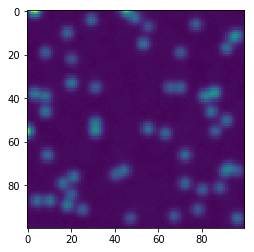

In [7]:
plt.imshow(signal[7])

In [9]:
filtered_detected

array([[[251.51739375, 250.20251505, 250.44309475, ..., 246.94836765,
         247.00794798, 243.63969389],
        [249.74020755, 247.58361036, 248.47885889, ..., 247.80201242,
         247.4254119 , 247.10673972],
        [248.59049587, 247.76405281, 248.67664587, ..., 249.66518779,
         248.44020329, 248.7973539 ],
        ...,
        [252.67590979, 251.17961856, 250.67586487, ..., 300.14836316,
         283.76099329, 267.14793462],
        [254.48303649, 251.33603833, 249.80203829, ..., 277.36504456,
         269.94033974, 259.84589265],
        [251.65800554, 251.1851028 , 248.3739755 , ..., 259.31761328,
         256.51089809, 254.27800459]],

       [[346.8519833 , 428.90590164, 509.07880881, ..., 248.64417283,
         248.16042238, 245.67547145],
        [315.82851721, 367.01445496, 422.69140696, ..., 249.58884712,
         247.5423128 , 246.9123032 ],
        [286.33384051, 314.94085505, 347.28629569, ..., 248.4679977 ,
         249.50011853, 248.53116138],
        ...,
